In [ ]:
# 라이브러리 import 및 TensorFlow 버전 확인

import tensorflow as tf
import numpy as np
import pandas as pd

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


In [ ]:
# 데이터 다운로드
path_to_train_file = tf.keras.utils.get_file(
    'train.txt',
    'https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt'
)
path_to_test_file = tf.keras.utils.get_file(
    'test.txt',
    'https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt'
)

In [ ]:
# IN - 텍스트로 로드
path_to_train_file = tf.keras.utils.get_file(
    'train.txt',
    'https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt'
)
path_to_test_file = tf.keras.utils.get_file(
    'test.txt',
    'https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt'
)

train_text = open(path_to_train_file, 'rb').read().decode(encoding='utf-8')
test_text = open(path_to_test_file, 'rb').read().decode(encoding='utf-8')

print('Length of train text: {} characters'.format(len(train_text)))
print('Length of test text: {} characters'.format(len(test_text)))
print(train_text[:300])

Length of train text: 6937271 characters
Length of test text: 2318260 characters
id	document	label
9976970	아 더빙.. 진짜 짜증나네요 목소리	0
3819312	흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나	1
10265843	너무재밓었다그래서보는것을추천한다	0
9045019	교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정	0
6483659	사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다	1
5403919	막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.	0
7797314	원작의


In [ ]:
# IN - Y(정답 라벨) 데이터 만들기
train_Y = np.array([
    [int(row.split('\t')[2])]
    for row in train_text.split('\n')[1:]
    if row.count('\t') > 0
])

test_Y = np.array([
    [int(row.split('\t')[2])]
    for row in test_text.split('\n')[1:]
    if row.count('\t') > 0
])

print("train_Y shape:", train_Y.shape)
print("test_Y shape:", test_Y.shape)
print("train_Y sample:", train_Y[:5])

train_Y shape: (150000, 1)
test_Y shape: (50000, 1)
train_Y sample: [[0]
 [1]
 [0]
 [0]
 [1]]


In [ ]:
import re

def clean_str(string):
    string = re.sub(r"[^가-힣A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = re.sub(r"\'{2,}", "\'", string)
    string = re.sub(r"\'", "", string)

    return string.lower()

train_text_X = [row.split('\t')[1] for row in train_text.split('\n')[1:] if row.count('\t') > 0]
train_text_X = [clean_str(sentence) for sentence in train_text_X]
# 문장을 띄어쓰기 단위로 단어 분리
sentences = [sentence.split(' ') for sentence in train_text_X]
for i in range(5):
    print(sentences[i])

<>:13: SyntaxWarning: invalid escape sequence '\('
<>:14: SyntaxWarning: invalid escape sequence '\)'
<>:15: SyntaxWarning: invalid escape sequence '\?'
<>:13: SyntaxWarning: invalid escape sequence '\('
<>:14: SyntaxWarning: invalid escape sequence '\)'
<>:15: SyntaxWarning: invalid escape sequence '\?'
/tmp/ipython-input-2842916861.py:13: SyntaxWarning: invalid escape sequence '\('
  string = re.sub(r"\(", " \( ", string)
/tmp/ipython-input-2842916861.py:14: SyntaxWarning: invalid escape sequence '\)'
  string = re.sub(r"\)", " \) ", string)
/tmp/ipython-input-2842916861.py:15: SyntaxWarning: invalid escape sequence '\?'
  string = re.sub(r"\?", " \? ", string)


['아', '더빙', '진짜', '짜증나네요', '목소리']
['흠', '포스터보고', '초딩영화줄', '오버연기조차', '가볍지', '않구나']
['너무재밓었다그래서보는것을추천한다']
['교도소', '이야기구먼', '솔직히', '재미는', '없다', '평점', '조정']
['사이몬페그의', '익살스런', '연기가', '돋보였던', '영화', '!', '스파이더맨에서', '늙어보이기만', '했던', '커스틴', '던스트가', '너무나도', '이뻐보였다']


In [ ]:
VOCAB_SIZE = 2000   # 단어 사전 크기
MAX_LEN = 25        # 최대 문장 길이 (패딩 기준)

vectorize_layer = tf.keras.layers.TextVectorization(
    standardize='lower_and_strip_punctuation',  # 소문자 변환 + 구두점 제거
    split='whitespace',                         # 띄어쓰기 기준 토큰화
    max_tokens=VOCAB_SIZE,                      # 단어 사전 크기
    output_mode='int',                          # 정수 인코딩
    output_sequence_length=MAX_LEN              # 자동 패딩
)

vectorize_layer.adapt(train_text_X)  # 단어 사전 학습
# 텍스트를 정수 시퀀스로 변환 (패딩 포함)
train_X = vectorize_layer(train_text_X)

print(train_X[:5])

tf.Tensor(
[[  23  902    5    1 1097    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [ 586    1    1    1    1    1    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [   1    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [   1    1   68  345   28   33    1    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [   1    1  102    1    2    1    1  844    1    1  570    1    0    0
     0    0    0    0    0    0    0    0    0    0    0]], shape=(5, 25), dtype=int64)


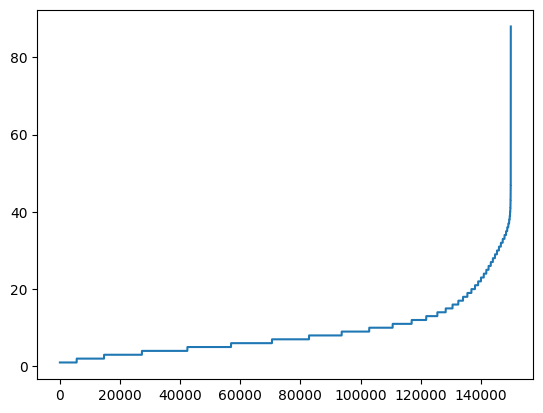

142587


In [ ]:
import matplotlib.pyplot as plt
sentence_len = [len(sentence) for sentence in sentences]
sentence_len.sort()
plt.plot(sentence_len)
plt.show()

print(sum([int(l<=25) for l in sentence_len]))

In [ ]:
test_text_X = [
    row.split('\t')[1]
    for row in test_text.split('\n')[1:]
    if row.count('\t') > 0
]

# Week1에서 학습된 vectorize_layer 그대로 사용합니다.
test_X = vectorize_layer(test_text_X)

print("test_X shape:", test_X.shape)
print("test_Y shape:", test_Y.shape)

test_X shape: (50000, 25)
test_Y shape: (50000, 1)


In [ ]:
# 모델의 주요 설정값들을 미리 정의해줍니다.
VOCAB_SIZE = 2000
EMBEDDING_DIM = 128
MAX_LEN = 25
EPOCHS = 10
BATCH_SIZE = 32

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_shape=(MAX_LEN,)),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 25, 128)        │       256,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 264,321 (1.01 MB)

 Trainable params: 264,321 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_X, train_Y,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    verbose=1
)


Epoch 1/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 27s 7ms/step - accuracy: 0.6718 - loss: 0.5642 - val_accuracy: 0.7560 - val_loss: 0.4646
Epoch 2/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - accuracy: 0.7487 - loss: 0.4691 - val_accuracy: 0.7612 - val_loss: 0.4545
Epoch 3/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - accuracy: 0.7506 - loss: 0.4614 - val_accuracy: 0.7599 - val_loss: 0.4545
Epoch 4/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - accuracy: 0.7517 - loss: 0.4560 - val_accuracy: 0.7554 - val_loss: 0.4613
Epoch 5/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.7549 - loss: 0.4507 - val_accuracy: 0.7524 - val_loss: 0.4653
Epoch 6/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.7579 - loss: 0.4461 - val_accuracy: 0.7506 - val_loss: 0.4711
Epoch 7/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.7609 - loss: 0.4414 - val_accuracy: 0.7518 - val_loss: 0.4717
Epoch 8/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.7639 - loss: 0

In [ ]:
test_loss, test_acc = model.evaluate(test_X, test_Y, verbose=0)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Test Loss: 0.5005, Test Accuracy: 0.7346


In [ ]:
example_sentences = [
    "이 영화 진짜 재미있어요",
    "완전 지루하고 별로였음",
    "배우 연기는 좋았지만 스토리가 아쉬웠다"
]

example_seq = vectorize_layer(example_sentences)
pred = model.predict(example_seq)

for s, p in zip(example_sentences, pred):
    print(f"문장: {s}")
    print(f"긍정 확률: {p[0]:.4f}")
    print("결과:", "긍정 😊" if p[0] > 0.5 else "부정 😞")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
문장: 이 영화 진짜 재미있어요
긍정 확률: 0.9925
결과: 긍정 😊
문장: 완전 지루하고 별로였음
긍정 확률: 0.0076
결과: 부정 😞
문장: 배우 연기는 좋았지만 스토리가 아쉬웠다
긍정 확률: 0.0116
결과: 부정 😞


Epoch 1/30
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.7711 - loss: 0.4253 - val_accuracy: 0.7564 - val_loss: 0.4789
Epoch 2/30
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.7739 - loss: 0.4218 - val_accuracy: 0.7562 - val_loss: 0.4832
Epoch 3/30
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.7759 - loss: 0.4183 - val_accuracy: 0.7540 - val_loss: 0.4873
Epoch 4/30
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.7781 - loss: 0.4150 - val_accuracy: 0.7551 - val_loss: 0.4912
Epoch 5/30
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.7795 - loss: 0.4114 - val_accuracy: 0.7543 - val_loss: 0.4947
Epoch 6/30
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.7818 - loss: 0.4080 - val_accuracy: 0.7545 - val_loss: 0.4975
Epoch 7/30
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.7838 - loss: 0.4047 - val_accuracy: 0.7542 - val_loss: 0.5008
Epoch 8/30
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.7853 - loss: 0

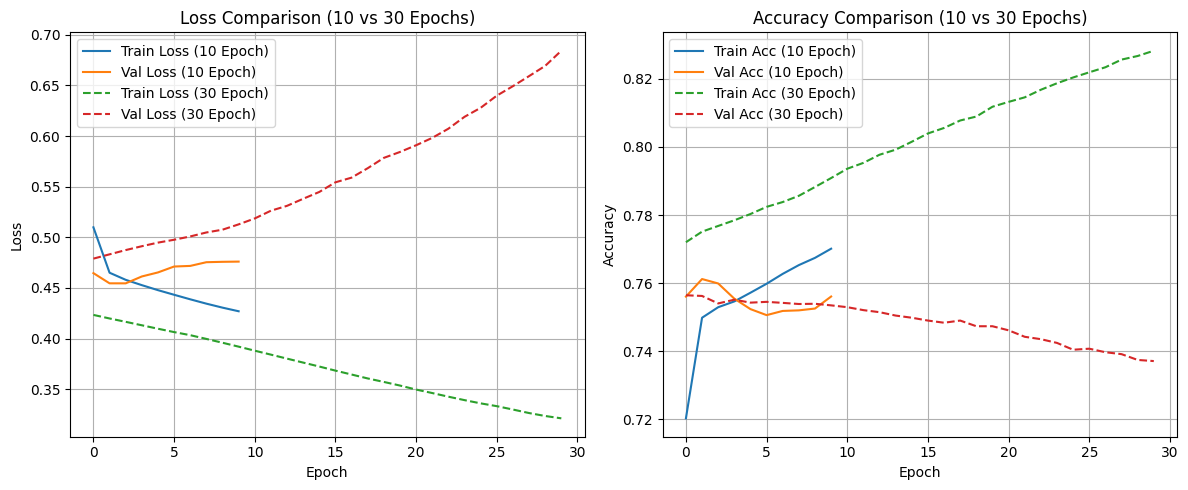

In [ ]:
# Epoch 수를 30으로 늘려 다시 학습해봅니다.
history_overfit = model.fit(
    train_X, train_Y,
    epochs=30,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    verbose=1
)

# 과적합 여부를 Loss/Accuracy 곡선으로 시각화
plt.figure(figsize=(12, 5))

# (1) Loss 비교
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss (10 Epoch)')
plt.plot(history.history['val_loss'], label='Val Loss (10 Epoch)')
plt.plot(history_overfit.history['loss'], label='Train Loss (30 Epoch)', linestyle='--')
plt.plot(history_overfit.history['val_loss'], label='Val Loss (30 Epoch)', linestyle='--')
plt.title('Loss Comparison (10 vs 30 Epochs)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# (2) Accuracy 비교
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc (10 Epoch)')
plt.plot(history.history['val_accuracy'], label='Val Acc (10 Epoch)')
plt.plot(history_overfit.history['accuracy'], label='Train Acc (30 Epoch)', linestyle='--')
plt.plot(history_overfit.history['val_accuracy'], label='Val Acc (30 Epoch)', linestyle='--')
plt.title('Accuracy Comparison (10 vs 30 Epochs)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.layers import SimpleRNN
import random

EMBEDDING_DIM = 128
EPOCHS = 10
BATCH_SIZE = 32

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

rnn_model = tf.keras.Sequential([
    tf.keras.Input(shape=(MAX_LEN,)),
    tf.keras.layers.Embedding(
        input_dim=VOCAB_SIZE,
        output_dim=EMBEDDING_DIM,
        input_length=MAX_LEN
    ),
    SimpleRNN(units=50), #RNN 사용
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

rnn_model.summary()
rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 25, 128)        │       256,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 50)             │         8,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         3,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 268,279 (1.02 MB)

 Trainable params: 268,279 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_rnn = rnn_model.fit(
	train_X, train_Y,
	epochs=EPOCHS,
	batch_size=BATCH_SIZE,
	validation_split=0.2,
	verbose=1
)

Epoch 1/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 50s 13ms/step - accuracy: 0.6589 - loss: 0.5898 - val_accuracy: 0.7465 - val_loss: 0.4764
Epoch 2/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 46s 12ms/step - accuracy: 0.7445 - loss: 0.4800 - val_accuracy: 0.7380 - val_loss: 0.4868
Epoch 3/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 47s 13ms/step - accuracy: 0.7523 - loss: 0.4615 - val_accuracy: 0.7440 - val_loss: 0.4770
Epoch 4/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 46s 12ms/step - accuracy: 0.7579 - loss: 0.4501 - val_accuracy: 0.7548 - val_loss: 0.4756
Epoch 5/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 47s 12ms/step - accuracy: 0.7622 - loss: 0.4421 - val_accuracy: 0.7492 - val_loss: 0.4803
Epoch 6/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 81s 12ms/step - accuracy: 0.7666 - loss: 0.4337 - val_accuracy: 0.7438 - val_loss: 0.4847
Epoch 7/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 47s 12ms/step - accuracy: 0.7699 - loss: 0.4295 - val_accuracy: 0.7455 - val_loss: 0.5121
Epoch 8/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 81s 12ms/step - accuracy: 0.7725 -

In [ ]:
test_loss, test_acc = rnn_model.evaluate(test_X, test_Y, verbose=0)
print(f"Rnn Test Loss: {test_loss:.4f}, Rnn Test Accuracy: {test_acc:.4f}")

Rnn Test Loss: 0.5143, Rnn Test Accuracy: 0.7345


In [ ]:
example_sentences = [
    "배우 연기는 좋았지만 스토리가 아쉬웠다",
    "스토리는 아쉬웠지만 배우 연기는 좋았다"
]

example_seq = vectorize_layer(example_sentences)
pred = rnn_model.predict(example_seq)

for s, p in zip(example_sentences, pred):
    print(f"문장: {s}")
    print(f"긍정 확률: {p[0]:.4f}")
    print("결과:", "긍정 😊" if p[0] > 0.5 else "부정 😞")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
문장: 배우 연기는 좋았지만 스토리가 아쉬웠다
긍정 확률: 0.2723
결과: 부정 😞
문장: 스토리는 아쉬웠지만 배우 연기는 좋았다
긍정 확률: 0.9295
결과: 긍정 😊


In [ ]:
example_sentences = [
    "배우 연기는 좋았지만 스토리가 아쉬웠다",
    "스토리는 아쉬웠지만 배우 연기는 좋았다"
]

example_seq = vectorize_layer(example_sentences)
pred = model.predict(example_seq)

for s, p in zip(example_sentences, pred):
    print(f"문장: {s}")
    print(f"긍정 확률: {p[0]:.4f}")
    print("결과:", "긍정 😊" if p[0] > 0.5 else "부정 😞")

In [ ]:
from tensorflow.keras.layers import LSTM
import random

EMBEDDING_DIM = 128
EPOCHS = 10
BATCH_SIZE = 32

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

lstm_model = tf.keras.Sequential([
  tf.keras.Input(shape=(MAX_LEN,)),
  tf.keras.layers.Embedding(
        input_dim=VOCAB_SIZE,
        output_dim=EMBEDDING_DIM
    ),
  LSTM(units=50),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid'),
])

lstm_model.summary()
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 25, 128)        │       256,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        35,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         3,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 295,129 (1.13 MB)

 Trainable params: 295,129 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_lstm = lstm_model.fit(train_X, train_Y, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2,verbose=1)

Epoch 1/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 71s 18ms/step - accuracy: 0.6569 - loss: 0.5693 - val_accuracy: 0.7553 - val_loss: 0.4589
Epoch 2/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 87s 20ms/step - accuracy: 0.7535 - loss: 0.4573 - val_accuracy: 0.7616 - val_loss: 0.4557
Epoch 3/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 68s 18ms/step - accuracy: 0.7607 - loss: 0.4421 - val_accuracy: 0.7610 - val_loss: 0.4603
Epoch 4/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 68s 18ms/step - accuracy: 0.7655 - loss: 0.4293 - val_accuracy: 0.7625 - val_loss: 0.4678
Epoch 5/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 81s 18ms/step - accuracy: 0.7721 - loss: 0.4161 - val_accuracy: 0.7603 - val_loss: 0.4788
Epoch 6/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 73s 19ms/step - accuracy: 0.7778 - loss: 0.4042 - val_accuracy: 0.7609 - val_loss: 0.4924
Epoch 7/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 68s 18ms/step - accuracy: 0.7844 - loss: 0.3906 - val_accuracy: 0.7574 - val_loss: 0.5175
Epoch 8/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 84s 19ms/step - accuracy: 0.7915 -

In [ ]:
example_sentences = [
    "배우 연기는 좋았지만 스토리가 아쉬웠다",
    "스토리는 아쉬웠지만 배우 연기는 좋았다"
]

example_seq = vectorize_layer(example_sentences)
pred = lstm_model.predict(example_seq)

for s, p in zip(example_sentences, pred):
    print(f"문장: {s}")
    print(f"긍정 확률: {p[0]:.4f}")
    print("결과:", "긍정 😊" if p[0] > 0.5 else "부정 😞")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
문장: 배우 연기는 좋았지만 스토리가 아쉬웠다
긍정 확률: 0.0082
결과: 부정 😞
문장: 스토리는 아쉬웠지만 배우 연기는 좋았다
긍정 확률: 0.8388
결과: 긍정 😊
